# Transformer Drills

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
import logging
import matplotlib.pyplot as plt
import math 
import random

## Configure Log Settings


In [2]:
logging.basicConfig(filename = "logs.log", format = "%(asctime)s -- %(message)s", datefmt='%m/%d/%Y %I:%M:%S %p', level = logging.INFO)

## Load Dataset

In [3]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
logging.info("Dataset Upload successfully")
logging.info(f"X training set shape:{X_train.shape}")
logging.info(f"y training set shape:{y_train.shape}")
logging.info(f"X test set shape:{X_test.shape}")
logging.info(f"y training set shape:{y_test.shape}")

## HyperParameters

In [4]:
###----------------------------------------------------------------------------------------
### Images 
###----------------------------------------------------------------------------------------
y_train = tf.keras.utils.to_categorical(y_train,100)
num_classes = 100
image_size = 72 
patch_size = 6
num_patches = int(image_size/patch_size)**2
patch_plot_size = int(image_size/patch_size)

###----------------------------------------------------------------------------------------
### Model
###----------------------------------------------------------------------------------------
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 256
epochs = 100
projection_dim = 128
mlp_dim = 128
transformer_layer = 10
multiheadattention_heads = 6
transformer_units = [
    projection_dim ** 2,
    projection_dim
]
mlp_units = [2048, 1024]
input_shape = (num_patches, projection_dim)




## Image Preprocessing (No Data Augmentation)


In [5]:
def normalize_images(images):
    images /=255
    return images

def resize_images(images):
    resized_batch = [tf.image.resize(tf.convert_to_tensor(image), size = (image_size, image_size)) for image in images]
    return tf.convert_to_tensor(resized_batch)


def create_patches(images, plot_sample = True):
    ###----------------------------------------------------------------------------------------
    ### Patch Creation for sample image
    ###----------------------------------------------------------------------------------------
    
    if plot_sample:
        # Pick a random image and resize to desired shape
        sample_image = images[random.randint(0, len(images))]
        sample_image = tf.image.resize(tf.convert_to_tensor(sample_image), size = (image_size, image_size))
        logging.info(f"Sample Image Shape: {sample_image.shape}")
        
        # Plotting Original Image
        fig = plt.figure(figsize=(7,7))
        fig.add_subplot()
        plt.imshow(sample_image)
        
        # Plotting Patched Image
        fig = plt.figure(figsize=(7,7))
        #Output of extract_patches method is a four dimensional tensor with shape (1, number of columns, number of rows, number of elements per patch)
        patched_image = tf.image.extract_patches(tf.expand_dims(sample_image,0),
                                                sizes = [1, patch_size, patch_size, 1],
                                                strides = [1, patch_size,patch_size, 1],
                                                rates = [1,1,1,1],
                                                padding = "VALID") 
        patched_image = tf.reshape(patched_image, (1,-1,patched_image.shape[-1])) # Output is reshape to be (1 image, number of patches, number of elements per patch)
        for i, _ in enumerate(range(patched_image.shape[1])): #For loop to display each patch in the form of the original image
            fig.add_subplot(patch_plot_size, patch_plot_size, i + 1)
            plt.imshow(tf.reshape(patched_image[0][i], (patch_size,patch_size,3)))
            plt.axis("off")
            
    ###----------------------------------------------------------------------------------------
    ### Patch Creation for entire batch
    ###----------------------------------------------------------------------------------------       
    patched_batch = tf.image.extract_patches(images,
                                                sizes = [1, patch_size, patch_size, 1],
                                                strides = [1, patch_size,patch_size, 1],
                                                rates = [1,1,1,1],
                                                padding = "VALID")
    patched_batch = tf.reshape(patched_batch, (patched_batch.shape[0], -1, patched_batch.shape[-1])) #(Batch Size, number of patches, number of elements per patch)
    return patched_batch

def positional_encoding(patched_batch):
    patch_projection = keras.layers.Dense(projection_dim)
    position_embedding = keras.layers.Embedding(input_dim = num_patches, output_dim = projection_dim)
    position = tf.range(start=0, limit=num_patches)
    encoded = [patch_projection(patched_image) + position_embedding(position) for patched_image in patched_batch]

    return tf.convert_to_tensor(encoded)


In [6]:
###----------------------------------------------------------------------------------------
### MLP Block for Transformer encoder and MLP Head
###----------------------------------------------------------------------------------------
def mlp_block(x, hidden_units, dropout_rate):
    for unit in hidden_units:
        x = keras.layers.Dense(unit, activation = tf.nn.gelu)(x)
        x = keras.layers.Dropout(rate = dropout_rate)(x)
    return x

In [7]:
def transformer_encoder():
    inputs = keras.Input(shape = input_shape) #(Batch Size, Number of Patches, Projection Dim)
    ###----------------------------------------------------------------------------------------
    ### Transformer Architecture 
    ###----------------------------------------------------------------------------------------
    for _ in range(transformer_layer):
        layer1 = keras.layers.LayerNormalization(epsilon = 1e-6)(inputs)
        layer1 = keras.layers.MultiHeadAttention(num_heads = multiheadattention_heads, key_dim = projection_dim, dropout=0.1)(layer1, layer1)
        skip1 = keras.layers.Add()([layer1, inputs])
        final_layer = keras.layers.LayerNormalization(epsilon = 1e-6)(skip1)
        final_layer = mlp_block(final_layer, transformer_units, dropout_rate = 0.1)
        skip2 = keras.layers.Add()([final_layer, skip1])
        
    encoder_output = tf.reduce_mean(skip2, axis = 1)
    features = mlp_block(encoder_output, mlp_units, dropout_rate = 0.5)
    
    logit = keras.layers.Dense(units = num_classes, kernel_initializer=tf.keras.initializers.zeros)(features)
    
    model = keras.Model(inputs = inputs, outputs = logit)
    model.summary()
    
    return model

        
    

In [8]:
def train_model(model):
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate, decay=weight_decay)
    checkpoint_path = "models/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = "val_Accuracy", save_best_only = True, save_weights_only = True)
    model.compile(optimizer=optimizer, 
                  loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics = [keras.metrics.CategoricalAccuracy(name = "Accuracy")])
                  
    history = model.fit(
        x = encoded_batch,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split = 0.2,
        callbacks = [checkpoint_callback],
        
    )
    
    return history

# Note: Clean up needed, rough draft finished

2023-03-06 13:46:39.967006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 32)]    0           []                               
                                                                                                  
 layer_normalization_18 (LayerN  (None, 144, 32)     64          ['input_1[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 144, 32)     16800       ['layer_normalization_18[0][0]', 
 eadAttention)                                                    'layer_normalization_18[0][0]'] 
                                                                                              

KeyboardInterrupt: 

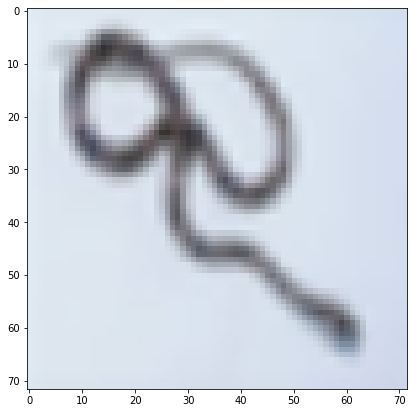

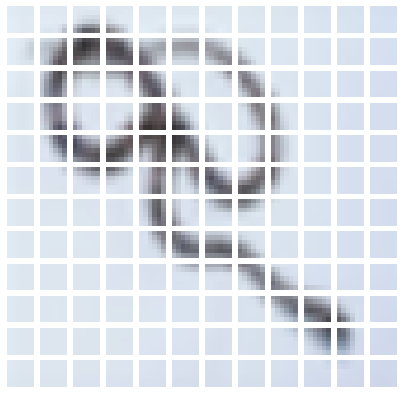

In [9]:
X_train = resize_images(X_train)
X_train = normalize_images(X_train)
patched_batch = create_patches(X_train, True)
encoded_batch = positional_encoding(patched_batch) 

transformer = transformer_encoder()

history = train_model(transformer)